# Mood Trend Prediction

A notebook that will take your mood data from Daylio app and make predictions based on it using a machine learning model.

## Problem Statement

**Objective:** To predict what mood would the user be for the next days. <br> A dashboard summarizing this can also help which is focused on people with Bipolar Disorder.

**Performance Measure:** RMSE and MAE

:**Assumption:** This is a regression problem because my data is daily. I need to get the scale of my mood each day and predict patterns to help me with my bipolar disorder.

## Data Preparation

### Scripts for loading the data

In [2]:
# get the data from daylio app
import pandas as pd
import numpy as np

# will be modified accordingly after deploying this
def load_mood_data():
    csv_path = "daylio_export_2024_08_14.csv"
    return pd.read_csv(csv_path)

mood = load_mood_data()

In [3]:
# prepare the data before pre-processing
def process_mood_data(mood):
  mood = mood.drop(["note_title", "note"], axis=1)
  mood["full_date"] = pd.to_datetime(mood["full_date"])
  mood = mood.set_index("full_date")
  return mood

mood = process_mood_data(mood)

### Check the data structure

In [4]:
# look at the data structure
mood.head()

,date,weekday,time,mood,activities
full_date,,,,,
2024-08-13,13 Aug,Tuesday,22:46,meh,relax | movies | hobby
2024-08-12,12 Aug,Monday,22:14,meh,grind
2024-08-11,11 Aug,Sunday,21:27,meh,sleep early | hobby
2024-08-10,10 Aug,Saturday,20:00,rad,grind
2024-08-09,9 Aug,Friday,20:22,awful,school | grind


In [5]:
mood.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 542 entries, 2024-08-13 to 2023-02-23
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        542 non-null    object
 1   weekday     542 non-null    object
 2   time        542 non-null    object
 3   mood        542 non-null    object
 4   activities  500 non-null    object
dtypes: object(5)
memory usage: 25.4+ KB


In [6]:
# check the entries for each day
mood['weekday'].value_counts()

,count
weekday,
Thursday,79
Monday,78
Friday,78
Tuesday,77
Sunday,77
Saturday,77
Wednesday,76


In [7]:
# check the mood counts per category
mood['mood'].value_counts()

,count
mood,
good,385
meh,129
bad,15
awful,7
rad,6


In [8]:
# check the activities associated to the mood
mood['activities'].value_counts()

,count
activities,
grind,86
school | grind,49
friends | school,38
friends | grind,26
school,24
...,...
friends | relax | shopping | school,1
reading | sleep early | self-love | hobby,1
family | sleep early | grind | hobby,1


In [9]:
# statistical summary of the data
mood.describe()

,date,weekday,time,mood,activities
count,542,542,542,542,500
unique,366,7,217,5,123
top,10 Aug,Thursday,23:59,good,grind
freq,3,79,81,385,86


### Create a Test Set before pre-processing

In [10]:
# create a test set
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

def create_time_series_splits(data, n_splits=5, random_seed=None):
  """
  Creates time series splits for training and testing.

  Args:
    data: The time series data (pandas DataFrame or Series).
    n_splits: The number of splits to create.
    random_seed: (Optional) Seed for random number generator for reproducibility.

  Returns:
    A generator yielding tuples of (train_data, test_data) for each split.
  """
  if random_seed is not None:
    np.random.seed(random_seed)

  tscv = TimeSeriesSplit(n_splits=n_splits)
  for train_index, test_index in tscv.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]
    yield train_data, test_data

# Example usage with a random seed for reproducibility:
for train_data, test_data in create_time_series_splits(mood, random_seed=42):
  # Train your model on train_data, evaluate on test_data
  print("Train data shape:", train_data.shape)
  print("Test data shape:", test_data.shape)

Train data shape: (92, 5)
Test data shape: (90, 5)
Train data shape: (182, 5)
Test data shape: (90, 5)
Train data shape: (272, 5)
Test data shape: (90, 5)
Train data shape: (362, 5)
Test data shape: (90, 5)
Train data shape: (452, 5)
Test data shape: (90, 5)


## Exploratory Data Analysis

In [11]:
# make a copy of the training set
mood_copy = train_data.copy()

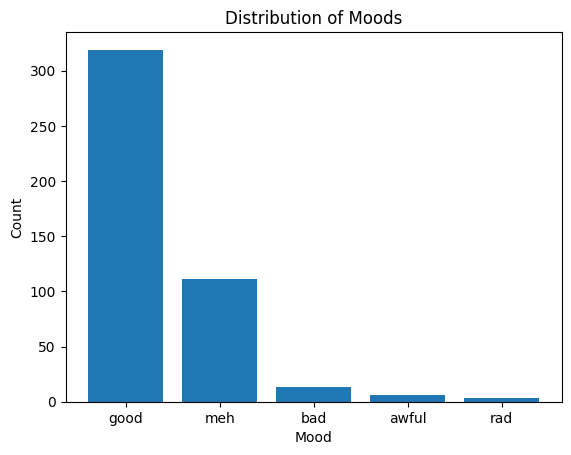

In [12]:
# visualize distribution of moods
import matplotlib.pyplot as plt

# Count the occurrences of each mood category
mood_counts = mood_copy['mood'].value_counts()

# Create a bar chart
plt.bar(mood_counts.index, mood_counts.values)
plt.xlabel('Mood')
plt.ylabel('Count')
plt.title('Distribution of Moods')
plt.show()

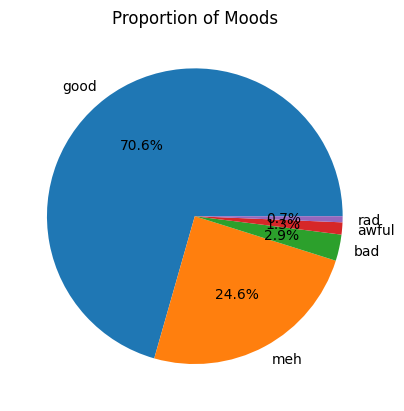

In [13]:
# visualize proportion of moods

# Calculate proportions for each mood category
mood_proportions = mood_counts / mood_counts.sum()

# Create a pie chart
plt.pie(mood_proportions, labels=mood_proportions.index, autopct='%1.1f%%')
plt.title('Proportion of Moods')
plt.show()

In [14]:
# install required package for the researchpy
!pip install -q --upgrade researchpy

In [15]:
# look for correlations of the categorical values
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import researchpy as rp

crosstab, test_results, expected = rp.crosstab(mood_copy['mood'], mood_copy['weekday'],
                                               test="chi-square",
                                               expected_freqs=True,
                                               prop="cell")

cramers_v = test_results['results'][2]
# Correct way to get degrees of freedom:
degrees_of_freedom = (len(crosstab.index) - 1) * (len(crosstab.columns) - 1)

print("Cramer's V:", cramers_v)
print("Degrees of Freedom:", degrees_of_freedom)

Cramer's V: 0.127
Degrees of Freedom: 35


**Interpretation:** Given the weak association indicated by Cramer's V and the relatively high degrees of freedom, it suggests that while there is some relationship between the categorical variables, it may not be strong or meaningful in a practical context.

In [16]:
# count the number of each mood for each month
mood_copy['month'] = mood_copy.index.to_period('M')
monthly_mood_counts = mood_copy.groupby('month')['mood'].value_counts().unstack(fill_value=0)
print(monthly_mood_counts)

mood     awful  bad  good  meh  rad
month                              
2023-05      0    0     5    3    0
2023-06      0    2    16   11    1
2023-07      0    1    25    6    0
2023-08      1    1    27    3    0
2023-09      0    1    22    7    0
2023-10      0    0    22    9    0
2023-11      1    2    19    9    0
2023-12      0    0    24    8    0
2024-01      1    1    27    2    0
2024-02      0    0    25    4    0
2024-03      0    2    25    4    0
2024-04      1    1    19    9    0
2024-05      1    1    11   18    0
2024-06      0    0    18   11    1
2024-07      0    1    28    2    0
2024-08      1    0     6    5    1


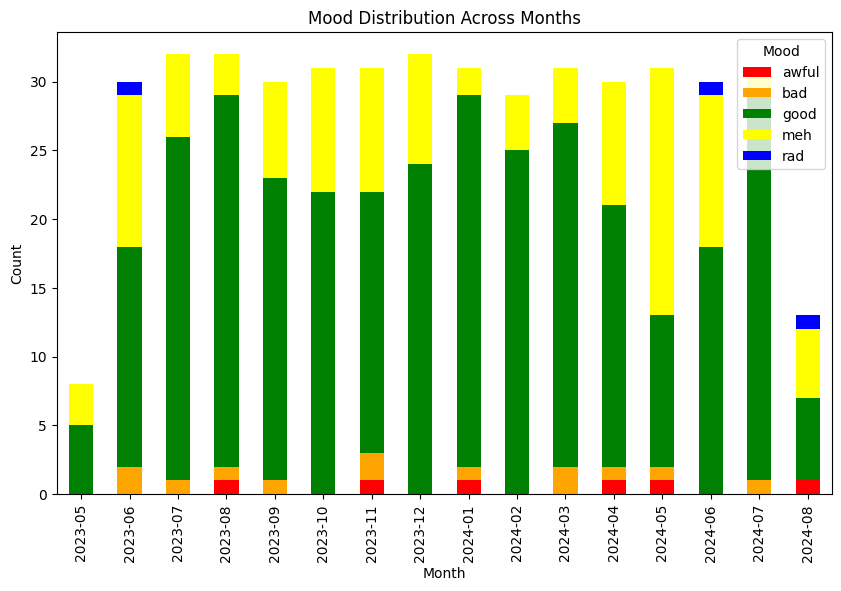

In [17]:
# visualize mood distribution across months
colors = {'awful': 'red', 'bad': 'orange', 'good': 'green', 'meh': 'yellow', 'rad': 'blue'}
monthly_mood_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors[c] for c in monthly_mood_counts.columns])
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Mood Distribution Across Months')
plt.legend(title='Mood')
plt.show()

**Next step:** Handle the categorical values by encoding them.

## Data Preprocessing

1. Get rid of the corresponding districts. <br>
2. Get rid of the whole attribute.<br>
3. Set the missing values to some value (zero, the mean, the median, etc.).<br>
This is called imputation.

In [58]:
# revert to the clean training set
mood_copy = train_data.copy()
mood_labels = test_data.copy()

In [59]:
# check missing values
mood_copy.isnull().sum()

,0
date,0
weekday,0
time,0
mood,0
activities,33


In [60]:
# drop the rows with null activities
mood_copy = mood_copy.dropna(subset=['activities'])

In [61]:
# check again if there's still n ull values
mood_copy.isnull().sum()

,0
date,0
weekday,0
time,0
mood,0
activities,0


In [62]:
mood_copy['activities'].head()

,activities
full_date,
2024-08-13,relax | movies | hobby
2024-08-12,grind
2024-08-11,sleep early | hobby
2024-08-10,grind
2024-08-09,school | grind


In [63]:
# handle text and categorical attributes
# define the mapping dictionary
mood_mapping = {'good': 3, 'rad': 4, 'meh': 2, 'awful': 0, 'bad': 1}

# map the values in the 'mood' column using the dictionary
mood_copy['mood_encoded'] = mood_copy['mood'].map(mood_mapping)

print(mood_copy)

              date    weekday   time   mood              activities  \
full_date                                                             
2024-08-13  13 Aug    Tuesday  22:46    meh  relax | movies | hobby   
2024-08-12  12 Aug     Monday  22:14    meh                   grind   
2024-08-11  11 Aug     Sunday  21:27    meh     sleep early | hobby   
2024-08-10  10 Aug   Saturday  20:00    rad                   grind   
2024-08-09   9 Aug     Friday  20:22  awful          school | grind   
...            ...        ...    ...    ...                     ...   
2023-05-30  30 May    Tuesday  23:59   good        friends | school   
2023-05-29  29 May     Monday  22:59    meh        friends | school   
2023-05-28  28 May     Sunday  21:37    meh                   grind   
2023-05-27  27 May   Saturday  20:00   good                   grind   
2023-05-24  24 May  Wednesday  20:00   good                  school   

            mood_encoded  
full_date                 
2024-08-13            

In [64]:
mood_copy['mood_encoded'].value_counts()

,count
mood_encoded,
3,301
2,102
1,9
0,4
4,3


In [65]:
# check the consistency of the encoding
mood_copy['mood'].value_counts()

,count
mood,
good,301
meh,102
bad,9
awful,4
rad,3


In [66]:
# drop unneeded columns
mood_copy = mood_copy.drop(['date', 'activities', 'mood'], axis=1)

In [67]:
# check the current dataframe
mood_copy.head()

,weekday,time,mood_encoded
full_date,,,
2024-08-13,Tuesday,22:46,2
2024-08-12,Monday,22:14,2
2024-08-11,Sunday,21:27,2
2024-08-10,Saturday,20:00,4
2024-08-09,Friday,20:22,0


In [ ]:
# feature engineering
# lagged features
# time differences
# rolling statistics
# external factors if naseparate na yung sa activities

In [22]:
# feature scaling and transformation

In [23]:
# transformation pipelines

## Select and Train a Model

In [24]:
# use pycaret for model selection ha

In [25]:
# train and evaluate on the training set

In [26]:
# better evaluation using cross-validation

## Fine Tuning

In [27]:
# grid search

In [28]:
# analyze best models and their errors

In [29]:
# evaluate your model on the test set